# Valley-selective circular dichroism in 2D hexagonal materials within BSE
**by <span style="color:darkgreen">Maximilian Schebek</span> for [<span style="color:DarkGoldenRod">exciting *fluorine*</span>](http://exciting.wikidot.com/fluorine)**

<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial you will learn how compute valley-selective circular dichroism within the Bethe-Salpeter-equation (**BSE**) framework as presented in [**Caruso, Schebek, et al., J. Phys. Chem. Lett. 2022, 13, 25, 5894–5899**](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.2c01034). As an example, this effect will be studied for Molybdenum disulfide (MoS2). Note that this is an advanced tutorial - make sure to be familiar with the basics of BSE as explained e.g. in the tutorials [**Excited states from BSE**](../tutorial_excited_states_from_bse/tutorial_excited_states_from_bse.ipynb) and [**Exciton Analysis and Visualization**](http://exciting.wikidot.com/oxygen-exciton-visualization) (not yet available as notebook).

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Preparation](#0)
    
[1. Theoretical Background: Bethe-Salpeter Equation](#1)
    
  - The BSE Hamiltonian
    
    
[2. Preliminary Step: Ground-State Calculation](#2)
    
[3. How to Run a BSE Calculation](#3)
    
  - Preparation of the Input File
  - Additional Information about the Calculation Workflow
  - Running exciting and Analysing the Results
  - Scaling and Convergence
  - Exercises
  
    
[4. BSE Calculations on Top of GW](#4)
    
[5. BSE Beyond the TDA](#5)

[Literature](#6)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Preparation</span>

Before running any Jupyter tutorials, please refer to the [**00_before_starting.md**](../00_before_starting.md) document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from exciting's root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

</div>

In order to run the scripts used in the **exciting** tutorials, it is important that the relevant environment variables are already defined in your **~/.bashrc** file as specified in **<span style="color:#00578A">How to set environment variables for tutorials scripts</span>**. However, this is not necessary for running the tutorials inside Jupyter Notebooks.

If you want to run this tutorial in a Jupyter Notebook, make sure to create an virutal environment as explained in [**How to start an exciting calculation**](tutorial1.ipynb). Subsequently, you should load all libraries needed for this tutorial by executing the following cell.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from excitingjupyter.utilities import set_plot_parameters


Finally, we determine the root directory of **exciting**, in which the binary executables as well as the species files are located.

In [4]:
import os
from excitingjupyter.utilities import get_exciting_root

exciting_root = get_exciting_root()
exciting_species = os.path.join(exciting_root, "species")
print(exciting_root)

/home1/codes/exciting_work


<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background: Valley-selective circular dichroism</span>
<!-- <details> -->
<summary><strong><span style="color:firebrick"> Click to show theoretical background!</span></strong></summary>

Before starting with the calculation, we briefly review the theoretical background. The 2-fold valley degeneracy of monolayer transition-metal
dichalcogenides (TMDs) makes them suitable candidates for the exploration of novel concepts in valleytronics. In particular, circularly polarized light can lead to a pronounced valleyselective circular dichroism (VCD), whereby absorption is governed by the formation of bound electron−hole pairs (excitons) at the ${\rm K}$ or $\overline{\rm K}$ valleys (denoted as $\mathcal{P}_{\rm K}$ and $\mathcal{P}_{\overline{\rm K}}$, respectively) in the Brillouin zone (BZ) depending on the light helicity. This effect is sketched in the following figure (copied from [**Caruso, Schebek, et al., J. Phys. Chem. Lett. 2022, 13, 25, 5894–5899**](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.2c01034)): Right handed polarized light only excites electrons in one valley of the Brillouin zone.

![BSE workflow](vscd_sketch.jpg)

The main result of a **BSE** calculation is the macroscopic dielectric function (especially the imaginary part $\varepsilon_2$), which can be related to experimentally observable quantities. In the case of VSCD, we are interested in the *valley-resolved* imaginary part of the dielectric function, which we denote as  $\varepsilon^{(\pm)}_{\rm 2,K}$ for right-handed ($-$) and left-handed ($+$) circularly polarized light. The index ${\rm K}$ indicates that this quantitiy only accounts for excitations within the coming from the ${\rm K}$-valley, the corresponding expression for the ${\rm \overline{K}}$-valley can be obtained by simply replacing the corresponding indices.

Within the theory of VSCD, the dielectric function $\varepsilon^{(\pm)}_{\rm 2,K}$ can be obtained in terms of valley-resolved *dichroic tensor* defined as

$$
\varepsilon^{(\pm)}_{\rm 2,K}(\omega) = \frac{1}{2}[\xi^{\rm K}_{xx}(\omega) + \xi^{\rm K}_{yy}(\omega)] \mp {\rm Im}[\xi^{\rm K}_{xy}(\omega)]
$$
with the dichroic tensor
$$
\xi^{\rm K}_{\alpha\beta}(\omega) = \frac{4\pi}{V}\sum_\lambda(t_{\rm K}^{\lambda,\alpha})^* t_{\rm K}^{\lambda,\beta}\delta(E^\lambda - \omega).
$$
The transition coefficients are given in terms of the BSE solutions $A^\lambda_{vc\mathbf{k}}$  by 
$$
\mathbf{t}_{\rm K}^\lambda = \sum_{vc}\sum^{\mathcal{P}_{\rm K}}_{\mathbf{k}}A^\lambda_{vc\mathbf{k}}\frac{\langle \psi_{c\mathbf{k}}|\hat{\mathbf{p}}|\psi_{c\mathbf{k}} \rangle}{\epsilon_{c\mathbf{k}} - \epsilon_{v\mathbf{k}}}.
$$


<!-- </details> -->


<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Preliminary Step: Ground-State Calculation</span>


**<span style="color:firebrick">Important note:</span>** All input parameters are given in **atomic units!**

As a preliminary step to calculate excited-state properties from **BSE**, a ground-state calculation has to be performed. In this tutorial we consider as an example LiF. As for all other tutorials, you can choose between executing all steps manually from your command line, or to simply execute the python cells in this Jupyter notebook.

In order to run calculations manually, create a directory named **run** and move into it.

```bash
$ mkdir run
$ cd run
```

Inside the directory **run** we create a sub-directory **GS** where we perform the preliminary ground state calculation:

```bash
$ mkdir GS
$ cd GS
```


By executing the following cell, the Notebook takes care of creating the directories. We first  create a directory **run**, in which we create two further subdirectories, **run/GS** and **run/BSE**, for the groundstate and BSE calculations, respectively.


In [1]:
%%bash
#create a directory to run exciting if it does not exist yet
mkdir -p run/GS


Inside the **GS** sub-directory we create the input file for LiF. In the <code><span style="color:green">structure</span></code> element we include the lattice parameter and basis vectors of MoS2, which has a hexagonal two-dimensional lattice, as well as the positions of the Mo and S atoms. In the <code><span style="color:green">groundstate</span></code> element, we include a **2×2×1** **k**-point mesh (<code><span style="color:mediumblue">ngridk</span></code>). Note that this will result in highly uncoverged calculations - however, denser grids would take too long to run for this tutorial. You are encouraged to run calculations with denser grids on a cluster, if available to you. 

For manual execution, copy and paste the following into the new file **input.xml**:


```xml
<input>
 
   <title> MoS2 with SOC </title>


  <structure speciespath="$EXCITINGROOT/species " cartesian="true"  tshift="false">

    <crystal scale = "6.0246">
      <basevect>   1.000000       0.0000000       0.000000000</basevect>
      <basevect>  -0.500000       0.8660254       0.000000000</basevect>
      <basevect>   0.000000       0.0000000       2.0</basevect>
    </crystal>
    <species speciesfile="Mo.xml" rmt="2.2000">
      <atom coord="0.0     3.47830442      6.01020121"/>
    </species>
    <species speciesfile="S.xml" rmt="2.2000">
      <atom coord="3.0123      1.73915221      3.0353247"/>
      <atom coord="3.0123      1.73915221      8.98501039"/>
    </species>
  </structure>       
  
<groundstate 
       do="fromscratch" 
       ngridk="2 2 1" 
       xctype="GGA_PBE" 
       nempty="2" 
       rgkmax="3"
       >
    <spin spinorb="true">
    </spin>
  </groundstate>


 
</input>
```

**<span style="color:firebrick">N.B.</span>**: Do not forget to replace the string **"\$EXCITINGROOT"** in **input.xml** by the actual value of the environment variable **\$EXCITINGROOT** by running

```bash
SETUP-excitingroot.sh
```


For an execution within the notebook, execute the following cell. It writes the complete input for the groundstate calculation as a string and saves it in the subdirectory **run/GS** as **input.xml**. While for storage or archiving purposes you may choose any name for the input file, running the **exciting** code requires that specifically the file **input.xml** is present.

In [14]:
species_path = os.path.join(exciting_root, "species")

input_str = f"""
<input>
 
  <title> MoS2 with SOC </title>


   <structure speciespath="{species_path}" cartesian="true"  tshift="false">

    <crystal scale = "6.0246">
      <basevect>   1.000000       0.0000000       0.000000000</basevect>
      <basevect>  -0.500000       0.8660254       0.000000000</basevect>
      <basevect>   0.000000       0.0000000       2.0</basevect>
    </crystal>
    <species speciesfile="Mo.xml" rmt="2.2000">
      <atom coord="0.0     3.47830442      6.01020121"/>
    </species>
    <species speciesfile="S.xml" rmt="2.2000">
      <atom coord="3.0123      1.73915221      3.0353247"/>
      <atom coord="3.0123      1.73915221      8.98501039"/>
    </species>
  </structure>       
  
<groundstate 
       do="fromscratch" 
       ngridk="2 2 1" 
       xctype="GGA_PBE" 
       nempty="2" 
       rgkmax="3"
       radialgridtype="cubic-2"
       >
    <spin spinorb="true">
    </spin>
  </groundstate>
 
</input>

"""

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run/GS/input.xml'), "w") as fid:
    fid.write(input_str)

Now the ground-state **SCF** can be started manually by executing the **exciting_smp** binary typing 
```bash
time exciting_smp
```

Here we used the **time** command before **exciting_serial** in order to get, at the end of the run, the elapsed time explicitly written on the screen.


Running **exciting** in python can alternatively be done within the Notebook by executing the following cell.

In [15]:
%%bash
# move into the run directory
cd run/GS
# Set up environment.
# Note that this is platform-specific. With the Modules package you can e.g. use
module unload intel-oneapi/2021.3
module load intel-oneapi/2021.3

# module load intel/2019
# run exciting
time $EXCITINGROOT/bin/exciting_serial input.xml;
# move back to parent directory 
cd ..

 ### Using specified input file: input.xml


   Elapsed time = 0m35s


<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. How to Run a BSE Calculation with VSCD</span>


**i) Preparation of the Input File**

Now we are ready to perform a **BSE** calculation using the **TDA**. To do this manually, move to the parent directory **run** and create a new folder which we name **BSE**. Then, we move into it: 

```bash
cd ..
mkdir BSE
cd BSE
```



This step can also be executed in the Notebook by running the following cell.

In [7]:
%%bash
mkdir -p run/BSE

Copy the necessary ground-state files from the **GS** folder into the **BSE** path with

```bash
cp ../GS/{STATE.OUT,EFERMI.OUT,input.xml} ./
```

This step can also be executed in the Notebook by running the following cell.

In [16]:
import shutil

groundstate_directory = 'run/GS'
bse_directory = 'run/BSE'

files = ['STATE.OUT', 'EFERMI.OUT']

source = os.path.join(groundstate_directory, files[0])
dest = os.path.join(bse_directory, files[0])

# Copy files form groundstate calculation to BSE directory
for file in files:
    source = os.path.join(groundstate_directory, file)
    dest = os.path.join(bse_directory, file)
    shutil.copyfile(source, dest)


We can then skip the ground-state calculation by setting  <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> in the <code><span style="color:green">groundstate</span></code> element of the input file.

To perform an excited-state calculation we must include the  <code><span style="color:green">xs</span></code> element in the input file:

```xml
...
  <xs 
      xstype="BSE" 
      ngridk="3 3 1" 
      vkloff="0.5 0.5 0.0"
      ngridq="3 3 1"
      nempty="100"
      gqmax="1.3"
      broad="0.0018"
      scissor="0.0"
      tappinfo="true"
      tevout="true">
 
      <energywindow 
         intv="0.0 0.5" 
         points="2400"/>
 
      <screening 
         screentype="full"
         nempty="100"/>
 
      <BSE
         bsetype="singlet"
         nstlbse="23 26 1 4" 
         dichroism="true"
	                        />
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>

 
   </xs>                 
...
```

The meaning of these attributes are explained in [**Excited states from BSE**](../tutorial_excited_states_from_bse/tutorial_excited_states_from_bse.ipynb). Note that for the calculation of VSCD, the only thing we have to is to set <code><span style="color:mediumblue">dichroism="true"</span></code>. Note that we set <code><span style="color:mediumblue">vkloff="0.5 0.5 0.0"</span></code>: This is needed in order to distribute the **k**-points around the high symmetry ${\rm K}$-points in a symmetric way. Leaving this out would prefer one or the other point in the calculation and  distort the result.

**iii) Running exciting and analysing the results**

We can now run the **BSE** calculation from the command line. 
```bash
time exciting_serial
```

If you run the calculation outside this Jupyter Notebook, you will see some strings printed on the screen while the calculation is running.  A successfully completed BSE run will produce the following lines:


```bash
Calculating RPA Dielectric Function:                100.000 
Calculating Screened Coulomb Potential:             100.000 
Calculating Screened Coulomb Matrix Elements:       100.000 
Calculating Plane-wave matrix elements:             100.000 
Calculating Exchange Interaction Matrix Elements:   100.000 
Solving BSE Eigenvalue Problem:                     100.000
```

Again, we can alternatively run **exciting** in python by first writing the file **input.xml** and subsequently executing the **exciting_smp** binary.



In [17]:
species_path = os.path.join(exciting_root, "species")

input_str = f"""
<input>
 
  <title> MoS2 with SOC </title>


   <structure speciespath="{species_path}" cartesian="true"  tshift="false">

    <crystal scale = "6.0246">
      <basevect>   1.000000       0.0000000       0.000000000</basevect>
      <basevect>  -0.500000       0.8660254       0.000000000</basevect>
      <basevect>   0.000000       0.0000000       2.0</basevect>
    </crystal>
    <species speciesfile="Mo.xml" rmt="2.2000">
      <atom coord="0.0     3.47830442      6.01020121"/>
    </species>
    <species speciesfile="S.xml" rmt="2.2000">
      <atom coord="3.0123      1.73915221      3.0353247"/>
      <atom coord="3.0123      1.73915221      8.98501039"/>
    </species>
  </structure>       
  
  <groundstate 
       do="skip" 
       ngridk="2 2 1" 
       xctype="GGA_PBE" 
       nempty="2" 
       rgkmax="3"
       radialgridtype="cubic-2"
       >
    <spin spinorb="true">
    </spin>
  </groundstate>


   <xs 
      xstype="BSE" 
      ngridk="3 3 1" 
      vkloff="0.5 0.5 0.0"
      ngridq="3 3 1"
      nempty="100"
      gqmax="1.3"
      broad="0.0018"
      scissor="0.0"
      tappinfo="true"
      tevout="true"
      dfoffdiag="true">
 
      <energywindow 
         intv="0.0 0.5" 
         points="2400"/>
 
      <screening 
         screentype="full"
         nempty="100"/>
 
      <BSE
         bsetype="singlet"
         nstlbse="23 26 1 4"
         dichroism="true"
	 />
 
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>
 
</xs>


</input>


"""

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run/BSE/input.xml'), "w") as fid:
    fid.write(input_str)

In [18]:
%%bash
# move into the run directory
cd run/BSE; 
# Set up environment
# Note that this is platform-specific. With the Modules package you can e.g. use
# module load intel/2019
# run exciting
time $EXCITINGROOT/bin/exciting_serial input.xml;
# move back to parent directory 
cd ..;

 ### Using specified input file: input.xml
Calculating RPA Dielectric Function:                100.000 
Calculating Screened Coulomb Potential:             100.000 
Calculating Screened Coulomb Matrix Elements:       100.000 
Calculating Plane-wave matrix elements:             100.000 
Calculating Exchange Interaction Matrix Elements:   100.000 
Solving BSE Eigenvalue Problem:                     100.000 


   Elapsed time = 0m22s


After the calculation has finished, we proceed with the analysis of the results. A number of files and folders are present in the working directory. Most of them contain technical information about the calculation that is not strictly related to the physical interpretation of the results. We are interested in plotting the optical absorption spectrum of MoS2 or, more precisely, the valley-resolved imaginary part of the dielectric function. The plot can be produced within this notebook by executing the following cell. In case you had problems with running the calculation or don't want to wait until it is finished, you can still plot the results from the provided reference data by setting  

```python
take_files_from_reference = True
```


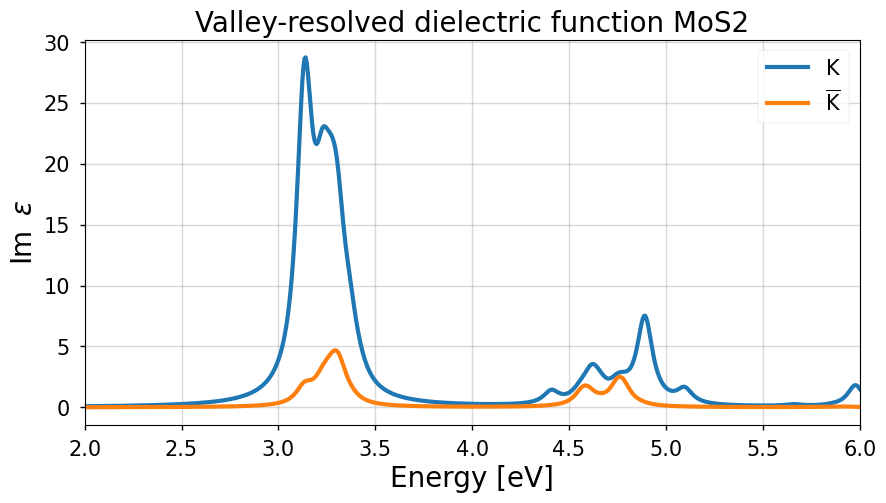

In [32]:
take_files_from_reference = True

# Get dichroic tensor from K valley
file_source = 'ref/DICHROIC_K/' if take_files_from_reference is True else 'run/BSE/DICHROIC_K/'

dichroic_k_xx = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_K_BSE-singlet-TDA-BAR_SCR-full_OC11.OUT'))
dichroic_k_yy = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_K_BSE-singlet-TDA-BAR_SCR-full_OC22.OUT'))
dichroic_k_xy = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_K_BSE-singlet-TDA-BAR_SCR-full_OC12.OUT'))

# Get dichroic tensor from K-BAR valley
file_source = 'ref/DICHROIC_KBAR/' if take_files_from_reference is True else 'run/BSE/DICHROIC_KBAR/'

dichroic_kbar_xx = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_KBAR_BSE-singlet-TDA-BAR_SCR-full_OC11.OUT'))
dichroic_kbar_yy = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_KBAR_BSE-singlet-TDA-BAR_SCR-full_OC22.OUT'))
dichroic_kbar_xy = np.genfromtxt(os.path.join(
    file_source,'DICHROIC_KBAR_BSE-singlet-TDA-BAR_SCR-full_OC12.OUT'))

# Build valley-resolved dielectric function from K and K_BAR valley for left-handed polarized light
eps_valley_resolved_k = 1 / 2 * (dichroic_k_xx[:,1] + dichroic_k_yy[:,1]) +  dichroic_k_xy[:,2]
eps_valley_resolved_kbar = 1 / 2 * (dichroic_kbar_xx[:,1] + dichroic_kbar_yy[:,1]) +  dichroic_kbar_xy[:,2]

# Get frequency grid from data
frequencies = dichroic_k_xx[:,0]

set_plot_parameters(figure_width=10, figure_height=5, fontsize=20)
fig, ax =  plt.subplots()
ax.plot(frequencies, eps_valley_resolved_k, label=r'${\rm K}$')
ax.plot(frequencies, eps_valley_resolved_kbar, label=r'$\overline{{\rm K}}$')

ax.set_xlabel('Energy [eV]')
ax.set_ylabel(r"$\mathrm{Im}\;\; \varepsilon$")
ax.set_title('Valley-resolved dielectric function MoS2')
ax.set_xlim(2,6)
ax.legend()
# ax.set_ylim(0,8)
plt.show()

We cleary see that, in the low-energy region, the optical excitations almost exlusively stem from the ${\rm K}$ valley, whereas excitations from the $\overline{{\rm K}}$ valley  are suppressed. Note that for this example, we are plotting the dielectric function for left-handed circularly polarized light. You can try to modify the code to show the dielectric function for right-handed circularly polarized light. In this case, you should see that the contributions from the valleys switch, i.e. a strong contribution from the  $\overline{{\rm K}}$ valley and only a tiny contribution from the ${\rm K}$ valley.